#### 什么是分类算法
分类算法通过对已知类别训练集的计算和分析,从中现类别规则并预测新数据的类别 分类算法是解决分类问题的方法,是数据挖掘、机器学习和模式识别中一个重要的研究领域 分类和回归是解决实际运营问题中非常重要的两种分析和挖掘方法。 常用的分类算法包括朴素贝叶斯、逻辑回归、决策树、随机森林、支持向量机等。 分类的主要用途和场景是“预测”,基于已有的样本预测新样本的所属类别,例如信用评级、风险等级、欺诈预测等。同时,它也是模式识别的重要组成部分,广泛应用于机器翻译,人脸 识别,医学诊断、手写字符识别、指纹识别的图像识别、语音识别、视频识别等领域。另外, 分类算法也可以用于知识抽取,通过模型找到潜在规律,帮助业务得到可执行的规则


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split  # 数据分区库
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve  # 导入指标库
from imblearn.over_sampling import SMOTE  # 过抽样处理库SMOTE
import matplotlib.pyplot as plt
import prettytable  # 导入表格库

In [2]:
!pip install imblearn 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
# 读取准备
f = open('./classification.csv')
raw_data = pd.read_csv(f, delimiter=',')  # 读取数据文件
X,y = raw_data.iloc[:, :-1],raw_data.iloc[:, -1]  # 分割X,y

In [4]:
# 数据基本审查
n_samples, n_features = X.shape  # 总样本量,总特征数
print('samples: {0}| features: {1} | na count: {2}'.format(n_samples, n_features,raw_data.isnull().any().count()))

samples: 1000| features: 41 | na count: 42


In [5]:
# 数据预处理
# 填充缺失值
X = X.fillna(X.mean())
# 样本均衡处理
#'''
model_smote = SMOTE()  # 建立SMOTE模型对象
X,y = model_smote.fit_resample(X,y)  # 输入数据并作过抽样处理

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
# 拆分数据集
X = pd.DataFrame(X,columns=raw_data.columns[:-1])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)  # 将数据分为训练集和测试集

In [8]:
# XGB分类模型训练
param_dist = {'objective': 'binary:logistic', 'n_estimators': 10,
              'subsample': 0.8, 'max_depth': 10, 'n_jobs': -1}  
# objective：指定分类对象是二元分类，n_estimators:树的数量，subsample：每棵树使用的样本比例为80%
model_xgb = xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train, y_train)
pre_y = model_xgb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
tn,fp,fn,tp = confusion_matrix(y_test,pre_y).ravel()    # 获得混淆矩阵
confusion_matrix_table = prettytable.PrettyTable(['','prediction-0','prediction-1'])      # 创建表格
confusion_matrix_table.add_row(['actual-0',tp,fn])
confusion_matrix_table.add_row(['actual-1',fp,tn])
print('confusion matrix \n',confusion_matrix_table)

confusion matrix 
 +----------+--------------+--------------+
|          | prediction-0 | prediction-1 |
+----------+--------------+--------------+
| actual-0 |     190      |      24      |
| actual-1 |      56      |     166      |
+----------+--------------+--------------+


In [10]:
# 核心评估指标
y_score = model_xgb.predict_proba(X_test)  # 获得决策树的预测概率
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])  # ROC
auc_s = auc(fpr, tpr)  # AUC
scores = [round(i(y_test, pre_y),3 )for  i in (accuracy_score,precision_score,\
                                     recall_score,f1_score)]
scores.insert(0,auc_s)
core_metrics = prettytable.PrettyTable()  # 创建表格实例
core_metrics.field_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row(scores)  # 增加数据
print('core metrics\n',core_metrics)

core metrics
 +--------------------+----------+-----------+--------+-------+
|        auc         | accuracy | precision | recall |   f1  |
+--------------------+----------+-----------+--------+-------+
| 0.8837458954281383 |  0.817   |   0.772   | 0.888  | 0.826 |
+--------------------+----------+-----------+--------+-------+


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain Split', ylabel='Features'>

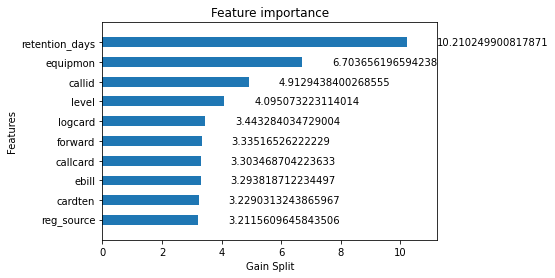

In [11]:
# 输出特征重要性
xgb.plot_importance(model_xgb,height=0.5,importance_type='gain',max_num_features=10,xlabel='Gain Split',grid=False)
#  importance_type:决定了特征重要性如何计算，可选方式包括：‘weight’,'gain','cover'
# 'weight'是特征在树中出现的次数
# ‘gain’是使用该特征分裂的平均增益值
# ‘cover’是作为分裂节点的覆盖样本比例

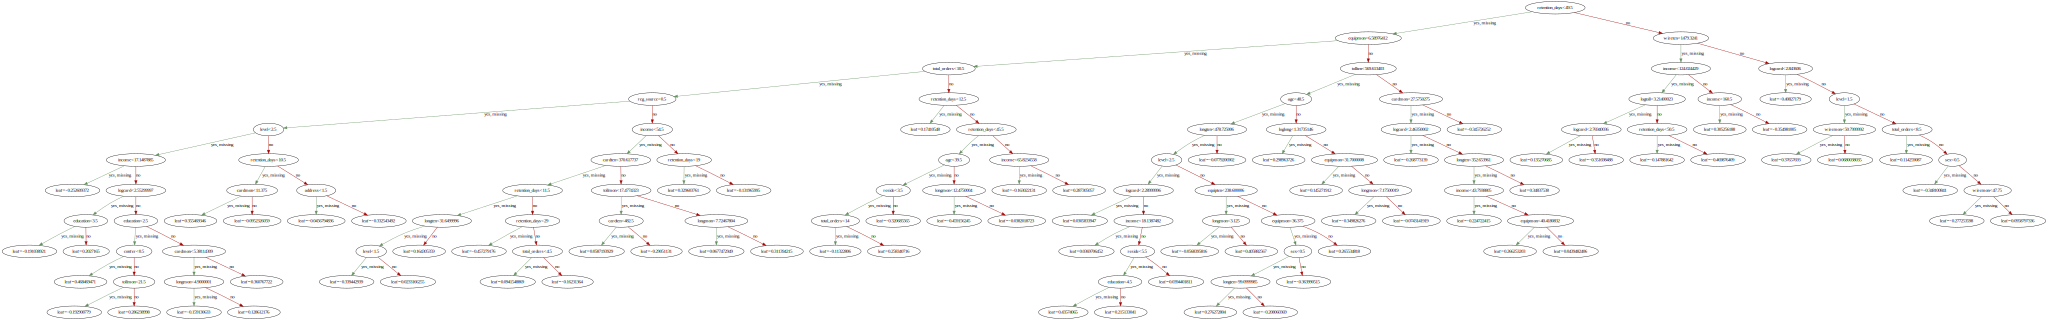

In [12]:
xgb.to_graphviz(model_xgb, num_trees=1, yes_color='#638e5e', no_color='#a40000') 

In [13]:
!pip install graphviz 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [14]:
# 前N条规则对应的用户数据
rule_depth_1 = X_test['retention_days']<30.5
rule_depth_2 = X_test['equipmon']<0.340951979
rule_depth_3 = X_test['retention_days']<12.5
rule_depth_4 = X_test['longmon']<4.8499999
rule_depth_5 = X_test['retention_days']<5.5
rule_list = [rule_depth_1,rule_depth_2,rule_depth_3,rule_depth_4,rule_depth_5]
rule_pd = [pd.DataFrame(i) for i in rule_list]
rule_pd_merge = pd.concat(rule_pd,axis=1)

# 遍历不同条件下用户的情况
for i in range(5):
    dyn_rules = rule_pd_merge.iloc[:,:i+1] # 取出top规则
    dyn_rules['is_true']=[all(i)==True for i in dyn_rules.values]# 得到都为true的record
    y_test_selected = y_test[dyn_rules['is_true']]
    y_pre_selected = y_score[dyn_rules['is_true']]
    y_pre_cal = y_pre_selected[:,1] >=0.5
    total_samples = len(y_pre_cal)
    is_churn = y_pre_cal.sum()
    churn_rate = float(is_churn)/total_samples
    # 计算样本比例
    print('total samples: {}'.format(total_samples))
    print('churn samples: {} | rate: {:.0%} '.format(is_churn,churn_rate))
    print('unchurn samples: {} | rate: {:.0%} '.format((total_samples-is_churn),(1-churn_rate)))
    print('-'*40)

total samples: 244
churn samples: 197 | rate: 81% 
unchurn samples: 47 | rate: 19% 
----------------------------------------
total samples: 94
churn samples: 54 | rate: 57% 
unchurn samples: 40 | rate: 43% 
----------------------------------------
total samples: 42
churn samples: 29 | rate: 69% 
unchurn samples: 13 | rate: 31% 
----------------------------------------
total samples: 29
churn samples: 18 | rate: 62% 
unchurn samples: 11 | rate: 38% 
----------------------------------------
total samples: 10
churn samples: 8 | rate: 80% 
unchurn samples: 2 | rate: 20% 
----------------------------------------


C:\Users\Administrator\AppData\Local\Temp/ipykernel_19188/989685986.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dyn_rules['is_true']=[all(i)==True for i in dyn_rules.values]# 得到都为true的record


In [15]:
rule_pd_merge.head()

,retention_days,equipmon,retention_days,longmon,retention_days
1370,True,False,False,False,False
482,True,False,True,False,False
1292,False,False,False,False,False
270,False,True,False,False,False
278,False,True,False,False,False
